## Setup & Configuration

Import des bibliothèques nécessaires et configuration de l'environnement.

In [39]:
import os
import sys
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import List, Dict, Tuple

# Configuration du style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Bibliothèques importées avec succès")

Bibliothèques importées avec succès


In [40]:
# Ajouter le chemin du projet au PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

# Charger les variables d'environnement
from dotenv import load_dotenv
load_dotenv(os.path.join(project_root, '.env'))

print("Configuration chargée")

Project root: c:\Users\ASUS\Desktop\A5\ESILV-Smart-assistant
Configuration chargée


In [41]:
# Importer les modules du projet
try:
    from Back.app.rag.rag import FaissRAGGemini
    from Back.app.agents.orchestrator import OrchestratorAgent
    from Back.app.agents.rag_agent import RAGAgent
    from Back.app.agents.contact_agent import ContactAgent
    
    print("Modules du projet importés avec succès")
except ImportError as e:
    print(f"Erreur d'import: {e}")
    print("Assurez-vous que le fichier .env est configuré correctement")

Modules du projet importés avec succès


## Initialisation du système

Initialisation du système RAG et des agents.

In [42]:
# Initialiser les agents
print("Initialisation des agents...")
rag_agent = RAGAgent()
contact_agent = ContactAgent()

# Initialiser l'orchestrateur
orchestrator = OrchestratorAgent()
orchestrator.register_agent(rag_agent)
orchestrator.register_agent(contact_agent)

print("Tous les agents sont prêts")

Initialisation des agents...
Index PDFs charge : 98 chunks
Index URLs scraped charge : 719 chunks
Modele Vertex AI : gemini-2.0-flash-exp
Modele d'embedding sera charge a la premiere utilisation
RAG Agent initialisé avec succès
Contact Agent initialisé avec succès
Agent enregistré: RAG Agent
Agent enregistré: Contact Agent
Tous les agents sont prêts


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


## Dataset de test

Définition des questions de test couvrant différentes catégories :
- **Programmes** : Questions sur les formations
- **Admission** : Procédures d'inscription
- **Campus** : Vie étudiante et infrastructures
- **Contact** : Demandes de contact
- **Général** : Informations diverses

In [43]:
# Dataset de questions de test
test_queries = [
    # Programmes académiques
    {
        "query": "Quels sont les programmes d'ingénieur proposés par l'ESILV ?",
        "category": "programmes",
        "expected_type": "rag"
    },
    {
        "query": "Comment se déroule le cycle ingénieur à l'ESILV ?",
        "category": "programmes",
        "expected_type": "rag"
    },
    {
        "query": "Quelles sont les spécialisations disponibles en dernière année ?",
        "category": "programmes",
        "expected_type": "rag"
    },
    
    # Admission
    {
        "query": "Comment intégrer l'ESILV après le bac ?",
        "category": "admission",
        "expected_type": "rag"
    },
    {
        "query": "Quels sont les frais de scolarité à l'ESILV ?",
        "category": "admission",
        "expected_type": "rag"
    },
    {
        "query": "Quelles sont les dates des concours d'admission ?",
        "category": "admission",
        "expected_type": "rag"
    },
    
    # Campus et vie étudiante
    {
        "query": "Où se situe le campus de l'ESILV ?",
        "category": "campus",
        "expected_type": "rag"
    },
    {
        "query": "Quelles sont les associations étudiantes disponibles ?",
        "category": "campus",
        "expected_type": "rag"
    },
    {
        "query": "Y a-t-il des logements étudiants à proximité ?",
        "category": "campus",
        "expected_type": "rag"
    },
    
    # Contact
    {
        "query": "Je souhaite être contacté pour plus d'informations",
        "category": "contact",
        "expected_type": "contact"
    },
    {
        "query": "Comment puis-je prendre rendez-vous avec un conseiller ?",
        "category": "contact",
        "expected_type": "contact"
    },
    
    # Questions générales
    {
        "query": "Quelle est l'histoire de l'ESILV ?",
        "category": "general",
        "expected_type": "rag"
    },
    {
        "query": "Quels sont les partenariats internationaux de l'école ?",
        "category": "general",
        "expected_type": "rag"
    },
    {
        "query": "L'ESILV propose-t-elle des stages à l'étranger ?",
        "category": "general",
        "expected_type": "rag"
    },
    {
        "query": "Quels sont les débouchés professionnels après l'ESILV ?",
        "category": "general",
        "expected_type": "rag"
    }
]

print(f"Dataset de test : {len(test_queries)} questions")
print(f"   - Programmes: {sum(1 for q in test_queries if q['category'] == 'programmes')}")
print(f"   - Admission: {sum(1 for q in test_queries if q['category'] == 'admission')}")
print(f"   - Campus: {sum(1 for q in test_queries if q['category'] == 'campus')}")
print(f"   - Contact: {sum(1 for q in test_queries if q['category'] == 'contact')}")
print(f"   - Général: {sum(1 for q in test_queries if q['category'] == 'general')}")

Dataset de test : 15 questions
   - Programmes: 3
   - Admission: 3
   - Campus: 3
   - Contact: 2
   - Général: 4


## Exécution des tests

Exécution de toutes les requêtes et mesure des performances.

In [44]:
def evaluate_query(query_data: Dict, orchestrator) -> Dict:
    """
    Évalue une requête et mesure ses performances
    
    Args:
        query_data: Dictionnaire contenant la requête et les métadonnées
        orchestrator: Agent orchestrateur
    
    Returns:
        Dictionnaire avec les résultats et métriques
    """
    query = query_data['query']
    
    # Mesurer le temps de réponse
    start_time = time.time()
    
    try:
        # Obtenir la réponse de l'orchestrateur (utiliser route au lieu de route_query)
        response = orchestrator.route(query)
        
        latency = time.time() - start_time
        
        # Extraire l'agent utilisé
        agent_used = response.get('agent_used', 'unknown')
        # Mapper les noms d'agents pour correspondre aux expected_type
        if 'rag' in agent_used.lower():
            agent_used = 'rag'
        elif 'contact' in agent_used.lower():
            agent_used = 'contact'
        
        answer = response.get('response', '')
        
        # Vérifier si l'agent utilisé correspond à ce qui est attendu
        correct_routing = agent_used == query_data['expected_type']
        
        return {
            'query': query,
            'category': query_data['category'],
            'expected_agent': query_data['expected_type'],
            'actual_agent': agent_used,
            'correct_routing': correct_routing,
            'response': answer,
            'response_length': len(answer),
            'latency': latency,
            'success': response.get('success', True),
            'timestamp': datetime.now().isoformat()
        }
    
    except Exception as e:
        latency = time.time() - start_time
        return {
            'query': query,
            'category': query_data['category'],
            'expected_agent': query_data['expected_type'],
            'actual_agent': 'error',
            'correct_routing': False,
            'response': str(e),
            'response_length': 0,
            'latency': latency,
            'success': False,
            'timestamp': datetime.now().isoformat()
        }

In [45]:
# Exécuter tous les tests
print("🚀 Début de l'évaluation...\n")

results = []
for i, query_data in enumerate(test_queries, 1):
    print(f"[{i}/{len(test_queries)}] Test: {query_data['query'][:50]}...")
    
    result = evaluate_query(query_data, orchestrator)
    results.append(result)
    
    status = "✅" if result['success'] else "❌"
    print(f"    {status} Agent: {result['actual_agent']} | Latence: {result['latency']:.2f}s\n")
    
    # Pause de 3 secondes pour éviter les limites de quota API
    time.sleep(3)

print("Évaluation terminée!")

🚀 Début de l'évaluation...

[1/15] Test: Quels sont les programmes d'ingénieur proposés par...

Intention détectée: information
Routage vers: RAG Agent
Chargement du modèle d'embedding...
Téléchargement depuis HuggingFace: paraphrase-multilingual-MiniLM-L12-v2
Modèle chargé avec succès

Recherche: 'Quels sont les programmes d'ingénieur proposés par l'ESILV ?'
Top 5 chunks pertinents:
  1. Score: 0.6807 [URL] | Menu Majeures La construction des compétences de l’ingénieur 15 majeures pour se spécialiser dont 14...
     Source: https://www.esilv.fr/formations/cycle-ingenieur/majeures/
  2. Score: 0.6685 [URL] | Toutes les dates de rentrée 2025 des cursus de l’ESILV, école d’ingénieurs généraliste du Pôle Léona...
     Source: https://www.esilv.fr/les-dates-de-la-rentree-a-lesilv/
  3. Score: 0.6672 [URL] | , ancrée dans les transitions Projets hybrides EMLV-ESILV dès la 1re année, avec des sujets réels au...
     Source: https://www.esilv.fr/formations/double-diplome-ingenieur-manager/
  

Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\google\api_core\grpc_helpers.py", line 76, in error_remapped_callable
    return callable_(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 277, in __call__
    response, ignored_call = self._with_call(
                             ^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 332, in _with_call
    return call.result(), call
           ^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_channel.py", line 440, in result
    raise self
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 315, in continuation
    response, call = self._thunk(new_method).with_call(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\AS

[13/15] Test: Quels sont les partenariats internationaux de l'éc...

Intention détectée: information
Routage vers: RAG Agent

Recherche: 'Quels sont les partenariats internationaux de l'école ?'
Top 5 chunks pertinents:
  1. Score: 0.6305 [URL] | ur devenir Ingénieur – Actuaire avec des écoles renommées en France : Paris Dauphine, l’ISUP, l’EURI...
     Source: https://www.esilv.fr/formations/cycle-ingenieur/majeures/actuariat/
  2. Score: 0.6208 [URL] | L’internationalisation dès la 3ᵉ année La dimension internationale est l’un des enjeux du cycle ingé...
     Source: https://www.esilv.fr/formations/cycle-ingenieur/
  3. Score: 0.6085 [URL] | es technologies de rupture et les insère dans de nouvelles visions de la société ou sur un nouveau m...
     Source: https://www.esilv.fr/formations/cycle-ingenieur/majeures/creative-technology/
  4. Score: 0.6076 [URL] | Les deux périodes de stages, l’une obligatoire et l’autre optionnelle, peuvent également être effect...
     Source: https://w

Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\google\api_core\grpc_helpers.py", line 76, in error_remapped_callable
    return callable_(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 277, in __call__
    response, ignored_call = self._with_call(
                             ^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 332, in _with_call
    return call.result(), call
           ^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_channel.py", line 440, in result
    raise self
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 315, in continuation
    response, call = self._thunk(new_method).with_call(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\AS

[14/15] Test: L'ESILV propose-t-elle des stages à l'étranger ?...

Intention détectée: information
Routage vers: RAG Agent

Recherche: 'L'ESILV propose-t-elle des stages à l'étranger ?'
Top 5 chunks pertinents:
  1. Score: 0.5658 [URL] | Toutes les dates de rentrée 2025 des cursus de l’ESILV, école d’ingénieurs généraliste du Pôle Léona...
     Source: https://www.esilv.fr/les-dates-de-la-rentree-a-lesilv/
  2. Score: 0.5507 [URL] | de 40 équipes venues de 20 universités internationales, dont Oxford et la Technische Universität Mün...
     Source: https://www.esilv.fr/formations/cycle-ingenieur/majeures/fintech/
  3. Score: 0.5500 [URL] | Les deux périodes de stages, l’une obligatoire et l’autre optionnelle, peuvent également être effect...
     Source: https://www.esilv.fr/formations/bachelor-technologie-management/
  4. Score: 0.5450 [URL] | s compétences de l’entreprise et de l’école, dans un objectif conjoint de formation d’un ingénieur. ...
     Source: https://www.esilv.fr/format

Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\google\api_core\grpc_helpers.py", line 76, in error_remapped_callable
    return callable_(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 277, in __call__
    response, ignored_call = self._with_call(
                             ^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 332, in _with_call
    return call.result(), call
           ^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_channel.py", line 440, in result
    raise self
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\grpc\_interceptor.py", line 315, in continuation
    response, call = self._thunk(new_method).with_call(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\AS


Gemini est indisponible. Voici un resume basique des documents trouves:
    ✅ Agent: rag | Latence: 0.20s

Évaluation terminée!


In [46]:
# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results)

# Sauvegarder les résultats
output_dir = os.path.join(project_root, 'notebooks', 'evaluation_results')
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = os.path.join(output_dir, f'evaluation_{timestamp}.json')

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"Résultats sauvegardés: {output_file}")

# Afficher un aperçu
df_results.head()

Résultats sauvegardés: c:\Users\ASUS\Desktop\A5\ESILV-Smart-assistant\notebooks\evaluation_results\evaluation_20260105_105717.json


,query,category,expected_agent,actual_agent,correct_routing,response,response_length,latency,success,timestamp
0,Quels sont les programmes d'ingénieur proposés...,programmes,rag,rag,True,L'ESILV propose un cursus ingénieur avec 15 ma...,661,5.636480,True,2026-01-05T10:56:18.736330
1,Comment se déroule le cycle ingénieur à l'ESILV ?,programmes,rag,rag,True,Le cycle ingénieur à l'ESILV se déroule en tro...,369,0.923810,True,2026-01-05T10:56:22.661560
2,Quelles sont les spécialisations disponibles e...,programmes,rag,rag,True,Les extraits fournis ne listent pas les spécia...,221,0.790648,True,2026-01-05T10:56:26.453756
3,Comment intégrer l'ESILV après le bac ?,admission,rag,rag,True,"Pour intégrer l'ESILV après le bac, tu peux pa...",759,1.847176,True,2026-01-05T10:56:31.301982
4,Quels sont les frais de scolarité à l'ESILV ?,admission,rag,rag,True,Les frais de scolarité à l'ESILV sont les suiv...,488,1.394865,True,2026-01-05T10:56:35.698317


## Analyse des performances

### 1. Métriques globales

In [47]:
# Calculer les métriques globales
total_queries = len(df_results)
successful_queries = df_results['success'].sum()
success_rate = (successful_queries / total_queries) * 100

correct_routing = df_results['correct_routing'].sum()
routing_accuracy = (correct_routing / total_queries) * 100

avg_latency = df_results['latency'].mean()
median_latency = df_results['latency'].median()
max_latency = df_results['latency'].max()
min_latency = df_results['latency'].min()

avg_response_length = df_results['response_length'].mean()

print("=" * 60)
print("MÉTRIQUES GLOBALES")
print("=" * 60)
print(f"\nTaux de succès: {success_rate:.1f}% ({successful_queries}/{total_queries})")
print(f"Précision du routing: {routing_accuracy:.1f}% ({correct_routing}/{total_queries})")
print(f"\nLATENCE:")
print(f"   - Moyenne: {avg_latency:.2f}s")
print(f"   - Médiane: {median_latency:.2f}s")
print(f"   - Min: {min_latency:.2f}s")
print(f"   - Max: {max_latency:.2f}s")
print(f"\nLongueur moyenne des réponses: {avg_response_length:.0f} caractères")
print("=" * 60)

MÉTRIQUES GLOBALES

Taux de succès: 100.0% (15/15)
Précision du routing: 93.3% (14/15)

LATENCE:
   - Moyenne: 1.31s
   - Médiane: 0.93s
   - Min: 0.20s
   - Max: 5.64s

Longueur moyenne des réponses: 936 caractères


## Visualisations de latence

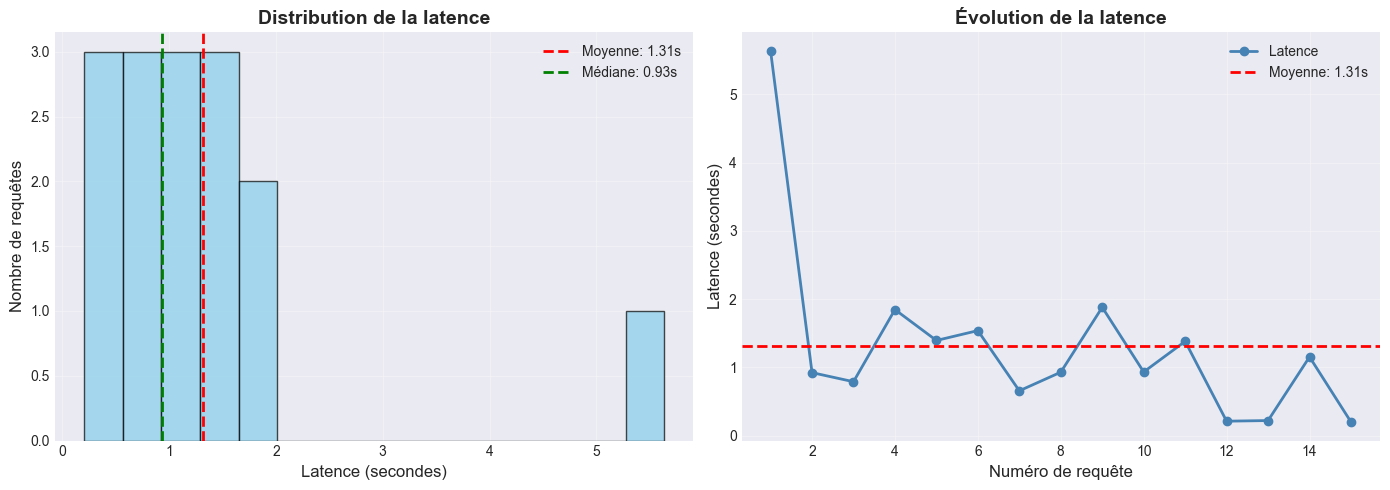

Graphiques sauvegardés: latency_analysis_20260105_105717.png


In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Distribution de la latence
axes[0].hist(df_results['latency'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(avg_latency, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {avg_latency:.2f}s')
axes[0].axvline(median_latency, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_latency:.2f}s')
axes[0].set_xlabel('Latence (secondes)', fontsize=12)
axes[0].set_ylabel('Nombre de requêtes', fontsize=12)
axes[0].set_title('Distribution de la latence', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Évolution de la latence
axes[1].plot(range(1, len(df_results) + 1), df_results['latency'].values, 
             marker='o', linewidth=2, markersize=6, color='steelblue', label='Latence')
axes[1].axhline(avg_latency, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {avg_latency:.2f}s')
axes[1].set_xlabel('Numéro de requête', fontsize=12)
axes[1].set_ylabel('Latence (secondes)', fontsize=12)
axes[1].set_title('Évolution de la latence', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'latency_analysis_{timestamp}.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Graphiques sauvegardés: latency_analysis_{timestamp}.png")

## Conclusion

Ce notebook démontre l'évaluation du système ESILV Smart Assistant avec :
-  **15 exemples de requêtes** couvrant 5 catégories
-  **Métriques de précision** : taux de succès et précision du routing
-  **Graphiques de latence** : distribution et évolution

Les résultats sont sauvegardés dans `notebooks/evaluation_results/`.